In [1]:
import sys
sys.path.insert(1, '../modules/')

import xarray as xr
import numpy as np
import gsw

import convenient_universal as uconv
import general_io as gio

In [6]:
thetao_file = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/thetao/gn/v20191108/thetao_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'
so_file = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/so/gn/v20191108/so_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'

## xarray

In [7]:
ds_thetao = xr.open_dataset(thetao_file)
ds_so = xr.open_dataset(so_file)

In [8]:
da_thetao = ds_thetao['thetao']
da_so = ds_so['so']

In [9]:
da_reference = da_thetao.isel({'time': 0}).drop('time')

In [10]:
da_reference

<xarray.DataArray 'thetao' (lev: 50, j: 300, i: 360)>
[5400000 values with dtype=float32]
Coordinates:
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        Diagnostic should be contributed even for models using co...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2019-11-08T18:41:01Z altered by CMOR: replaced missing va...

In [11]:
target_shape = da_thetao.shape[1:]
print(target_shape)

(50, 300, 360)


In [12]:
da_depth = da_thetao['lev'] * -1

In [13]:
broadcast_latitude = uconv.broadcast_array(da_thetao['latitude'].values, [1, 2], target_shape)

In [14]:
broadcast_depth = uconv.broadcast_array(da_depth.values, 0, target_shape)

In [15]:
pressure = gsw.p_from_z(broadcast_depth, broadcast_latitude)

In [17]:
da_pressure = xr.DataArray(pressure, dims=da_reference.dims, coords=da_reference.coords)

In [18]:
alpha = xr.apply_ufunc(gsw.alpha, da_so, da_thetao, da_pressure,
                       dask='parallelized', output_dtypes=[da_so.dtype])

In [19]:
alpha

<xarray.DataArray (time: 120, lev: 50, j: 300, i: 360)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1859-12-16T12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 -77.88 -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 80.5 81.5 82.5 83.5 ... 79.94 79.96 79.97 79.99

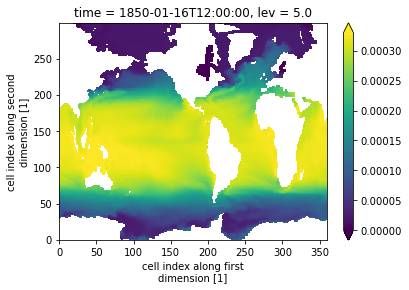

In [25]:
selection = alpha.isel({'time': 0, 'lev': 0}) #.where(alpha['alpha'].isel({'time': 0, 'lev': 0}) < 1.0)
selection.plot(vmin=0.0, vmax=0.00033)

## iris

In [14]:
thetao_cube, thetao_history = gio.combine_files(thetao_file, 'sea_water_potential_temperature', checks=True)
so_cube, so_history = gio.combine_files(so_file, 'sea_water_salinity', checks=True)

/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'thetao'
  warnings.warn(
/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'thetao'
  warnings.warn(
/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'so'
  warnings.warn(
/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'so'
  warnings.warn(


In [15]:
so_cube

<iris 'Cube' of sea_water_salinity / (g/kg) (time: 120; depth: 50; cell index along second dimension: 300; cell index along first dimension: 360)>

In [108]:
depth = thetao_cube.coord('depth').points * -1

In [109]:
target_shape = thetao_cube.shape[1:]
print(target_shape)

(50, 300, 360)


In [110]:
broadcast_depth = uconv.broadcast_array(depth, 0, target_shape)

In [111]:
broadcast_latitude = uconv.broadcast_array(thetao_cube.coord('latitude').points, [1, 2], target_shape)

## Results

In [22]:
beta_file = '/g/data/e14/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/beta/gn/v20191108/beta_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'

In [23]:
ds_beta = xr.open_dataset(beta_file)

In [24]:
ds_beta['beta'].mean()

<xarray.DataArray 'beta' ()>
array(0.)

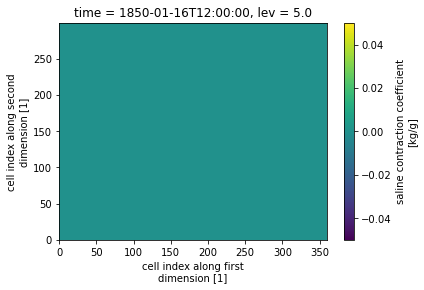

In [25]:
beta_da = ds_beta['beta'].isel({'time': 0, 'lev': 0})#.where(ds_beta['beta'].isel({'time': 0, 'lev': 0}) < 1.0)
beta_da.plot()

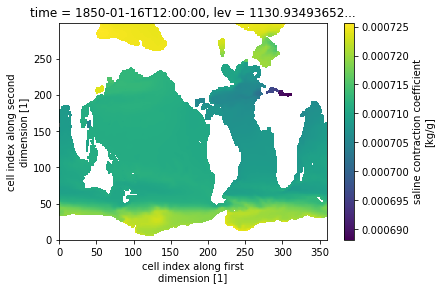

In [34]:
beta_da = ds_beta['beta'].isel({'time': 0, 'lev': 30}).where(ds_beta['beta'].isel({'time': 0, 'lev': 30}) < 1.0)
beta_da.plot()

In [2]:
alpha_file = '/g/data/e14/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/alpha/gn/v20191108/alpha_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'

In [3]:
ds_alpha = xr.open_dataset(alpha_file)

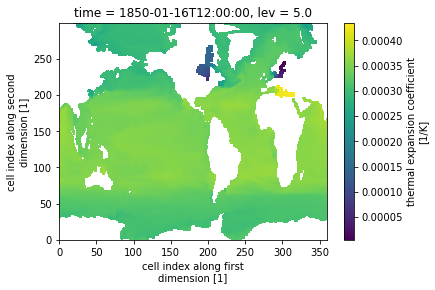

In [4]:
alpha_da = ds_alpha['alpha'].isel({'time': 0, 'lev': 0}).where(ds_alpha['alpha'].isel({'time': 0, 'lev': 0}) < 1.0)
alpha_da.plot()

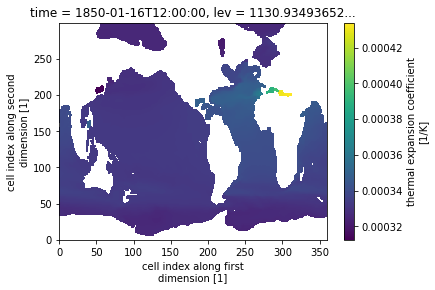

In [33]:
alpha_da = ds_alpha['alpha'].isel({'time': 0, 'lev': 30}).where(ds_alpha['alpha'].isel({'time': 0, 'lev': 30}) < 1.0)
alpha_da.plot()